# **Семинар 8**. Сегментация + UNet

Сегодня научимся сегментировать изображения на примере задачи отделения людей от заднего фона. В качестве модели будем использовать UNet-подобную сеть.

## План:

1. Данные для сегментации
2. UNet: 
    * Encoder
    * Decoder
    * Все вместе
3. Dice / Dice Loss
4. *UNet34

In [2]:
import matplotlib.pyplot   as plt
import torch.nn.functional as F
import torch.optim         as optim
import torch.nn            as nn
import numpy               as np

import torch
import glob
import cv2
import os

from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms
import torchvision.models     as models
import torch.utils.data       as data
import torch.utils.data       as data

import albumentations as A
import albumentations.pytorch

import warnings
warnings.filterwarnings('ignore')

### 1. Данные для сегментации

Будем использовать данные с первого этапа **PicsArt AI Hackathon**. Скачать [тут](https://drive.google.com/file/d/1Zc8iMETenxtk10GQEeNyMDY5PST7izjv/view?usp=sharing).
- Загрузим и распакуем данные
- Напишем класс `Dataset` для наших данных
- Посмотрим примеры данных

In [3]:
class HumanSegmentationDataset(Dataset):
    
    def __init__(self, root, split="train", transform=None):
        
        image_filenames = sorted(glob.glob(os.path.join(root, split, "*.jpg")))
        mask_filenames = []
        
        if split != "test":
            mask_filenames = []
            for image_fn in image_filenames:
                mask_fn = image_fn.replace(split, f"{split}_mask").replace("jpg", "png")
                if not os.path.exists(mask_fn):
                    raise FileNotFoundError(mask_fn)
                mask_filenames.append(mask_fn)
                
        self.image_filenames = image_filenames
        self.mask_filenames = mask_filenames
        self.transform = transform
        self.split = split
        
    def __getitem__(self, idx):
        
        # write some code here
        image = cv2.imread(self.image_filenames[idx]).astype(np.float32) / 255.
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        mask = None
        if self.split != "test":
            mask = cv2.imread(self.mask_filenames[idx], cv2.IMREAD_GRAYSCALE) / 255
            
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            
        image = transformed["image"]
        mask = transformed["mask"]
        mask = mask[None, ...]

        return image, mask


    def __len__(self):
        return len(self.image_filenames)

In [4]:
transform = A.Compose([
    A.pytorch.transforms.ToTensorV2(transpose_mask=True),
])

In [6]:
train_dataset = HumanSegmentationDataset(root="data", transform=transform)
valid_dataset = HumanSegmentationDataset(root="data", transform=transform, split="valid")
test_dataset  = HumanSegmentationDataset(root="data", transform=transform, split="test")

In [7]:
image, mask = train_dataset[0]

In [8]:
# check the output
image.shape, mask.shape

(torch.Size([3, 320, 240]), torch.Size([1, 320, 240]))

In [9]:
def show_image_with_mask(image, mask, predicted=None):
    
    image = (image * 255).astype(np.uint8)
    mask = (mask >= 0.5).astype(np.uint8) * 255
    
    plt.figure(figsize=(20, 8))
    
    plt.subplot(1, 6, 1)
    plt.imshow(image)
    plt.axis(False)

    plt.subplot(1, 6, 2)
    plt.imshow(mask)
    plt.axis(False)

    plt.subplot(1, 6, 3)
    image_masked = cv2.bitwise_and(image, image, mask=mask)
    plt.imshow(image_masked)
    plt.axis(False)

    if predicted is not None:
        predicted = (predicted * 255).astype(np.uint8)
        plt.subplot(1, 6, 4)
        plt.imshow(predicted)
        plt.axis(False)
        
        predicted_binary = (predicted >= 0.5 * 255).astype(np.uint8) * 255
        plt.subplot(1, 6, 5)
        plt.imshow(predicted_binary)
        plt.axis(False)
    
        image_masked = cv2.bitwise_and(image, image, mask=predicted_binary)
        plt.subplot(1, 6, 6)
        plt.imshow(image_masked)
        plt.axis(False)
    
    plt.show()

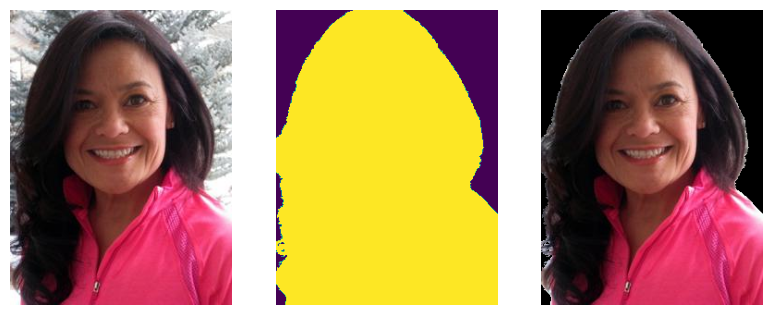

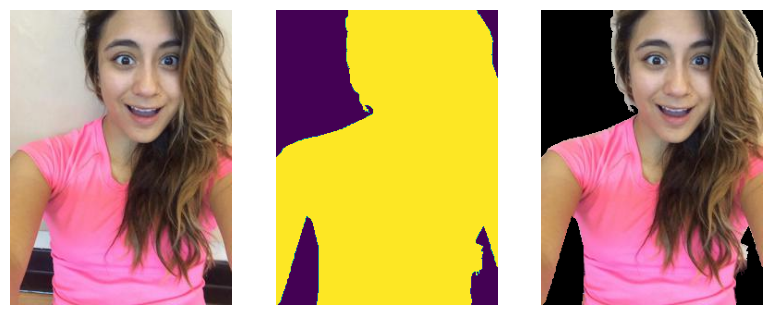

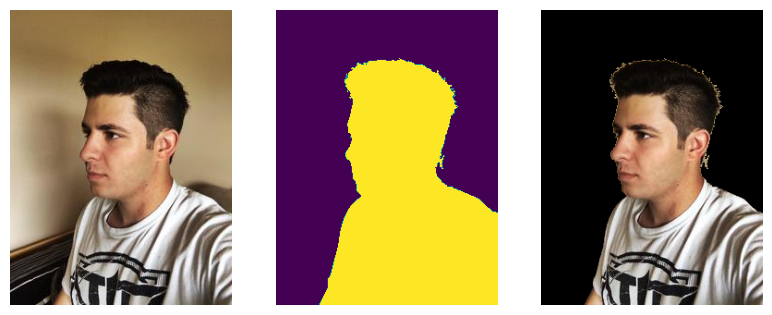

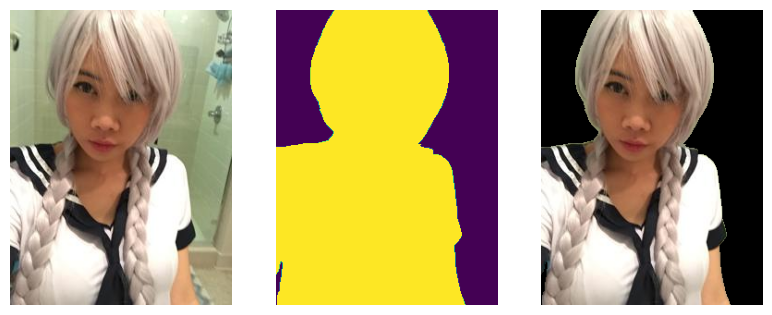

In [10]:
idxs = np.random.randint(0, len(train_dataset), 4)

sample_dataset = [train_dataset[i] for i in idxs]
sample_dataset = [(image.numpy().transpose(1, 2, 0), mask.numpy()[0]) for (image, mask) in sample_dataset]

for image, mask in sample_dataset:
    show_image_with_mask(image, mask)

### 2. Собираем UNet

![unet](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

#### 2.1. Encoder

In [11]:
def conv3x3(in_channels, out_channels, dilation=1):
    return nn.Conv2d(in_channels, out_channels, 3, padding=dilation, dilation=dilation)

Один **блок кодировщика** состоит из двух сверток, активаций и опционального батчнорма. **Блок не изменяет размеров HxW** входного тензора (это будем делать снаружи):

In [12]:
class EncoderBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels, batch_norm=False):
        super().__init__()
        
        self.batch_norm = batch_norm
        self.conv1 = conv3x3(in_channels, out_channels)
        
        if self.batch_norm:
            self.bn = nn.BatchNorm2d(out_channels)
        
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv1(x)
        
        if self.batch_norm:
            x = self.bn(x)
        
        x = self.relu1(x)
        x = self.conv2(x)
        
        if self.batch_norm:
            x = self.bn(x)
        
        x = self.relu2(x)
        return x

In [13]:
block = EncoderBlock(3, 16)
block

EncoderBlock(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU(inplace=True)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU(inplace=True)
)

In [14]:
x = torch.zeros(4, 3, 128, 128)

with torch.no_grad():
    print(block(x).shape)

torch.Size([4, 16, 128, 128])


Напишем класс энкодера, который и будет состоять из блоков.

**Задача 1**: реализовать конструктор класса `Encoder`.
* `num_filters` - это характерный размер блоков сети ("ширина"). В первом блоке должно быть `num_filters` признаков, во втором - вдвое больше, и т.д.
* `num_blocks` - количество блоков, после каждого блока стоит MaxPool2d (кроме последнего блока).


**Задача 2**: реализовать метод `forward` класса `Encoder`.
* Должен вернуть список с активациями каждого блока энкодера

In [15]:
class Encoder(nn.Module):
    
    def __init__(self, in_channels, num_filters, num_blocks):
        super().__init__()
        
        blocks = []
        for i in range(num_blocks):
            block = EncoderBlock(in_channels, num_filters *(2**i))
            in_channels = num_filters *(2**i)
            blocks.append(block)
            
        self.blocks = nn.Sequential(*blocks)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        acts = []
        
        for i, block in enumerate(self.blocks):
            x = block(x)
            acts.append(x)
            if i != len(self.blocks)-1:
                x = self.pool(x)
        
        return acts

In [16]:
encoder = Encoder(in_channels=3, num_filters=16, num_blocks=4)

assert len(encoder.blocks) == 4

In [17]:
x = torch.zeros(4, 3, 512, 512)
y = encoder(x)

assert len(y) == 4

assert y[0].size() == (4, 16, 512, 512)
assert y[1].size() == (4, 32, 256, 256)
assert y[2].size() == (4, 64, 128, 128)
assert y[3].size() == (4, 128, 64, 64)

In [18]:
print(encoder)

Encoder(
  (blocks): Sequential(
    (0): EncoderBlock(
      (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu1): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu2): ReLU(inplace=True)
    )
    (1): EncoderBlock(
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu1): ReLU(inplace=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu2): ReLU(inplace=True)
    )
    (2): EncoderBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu2): ReLU(inplace=True)
    )
    (3): EncoderBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu1): ReLU(inplace=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), 

#### 2.2. Decoder

С декодером несколько интереснее, каждый блок получает на вход 2 тензора, один "слева" (из ветки энкодера) и один "снизу" (из предыдушего блока декодера). Далее "нижний" тензор увеличивается в размерах (HxW) вдвое, конкатенируется с "левым" и сворачивается. Мы будем использовать самый простой вариант **билинейной интерполяции**:

In [19]:
class DecoderBlock(nn.Module):
    
    def __init__(self, out_channels):
        super().__init__()

        self.uppool = nn.Upsample(scale_factor=2, mode='bilinear')
        self.upconv = conv3x3(out_channels*2, out_channels)
        self.conv1 = conv3x3(out_channels*2, out_channels)

    def forward(self, down, left):
        x = self.uppool(down)
        x = self.upconv(x)
        x = torch.cat([x, left], 1)
        x = self.conv1(x)
        return x

![interp](https://matplotlib.org/stable/_images/sphx_glr_interpolation_methods_001.png)

Напишем теперь и декодер:

**Задача 3**: реализовать конструктор класса `Decoder`.
* `num_filters` - это характерный размер блоков сети ("ширина"). В первом блоке должно быть `num_filters` признаков, во втором - вдвое больше, и т.д.
* `num_blocks` - количество блоков, после каждого блока стоит MaxPool2d (кроме последнего блока).


**Задача 4**: реализовать метод `forward` класса `Decoder`.
* Должен получить активации из энкодера и вернуть один тензор

**NB**: Обратите внимание, что для корректной "склейки" у энкодера должно быть на 1 блок больше, чем у декодера.

In [20]:
class Decoder(nn.Module):
    
    def __init__(self, num_filters, num_blocks):
        super().__init__()
        
        blocks = list()
        for i in range(num_blocks):
            block = DecoderBlock(num_filters*(2**i))
            blocks.append(block)

        blocks = blocks[::-1]        
        
        #self.blocks = nn.Sequential(*blocks)
        self.blocks = nn.ModuleList(blocks)
    
    def forward(self, acts):
        
        up = acts[-1]

        for i, act in enumerate(acts[::-1][1:]):
            up = self.blocks[i](up, act)
       
        return up

In [21]:
decoder = Decoder(16, 3)

assert len(decoder.blocks) == 3

In [22]:
y_dec = decoder(y)

assert y_dec.size() == (4, 16, 512, 512)

In [23]:
decoder

Decoder(
  (blocks): ModuleList(
    (0): DecoderBlock(
      (uppool): Upsample(scale_factor=2.0, mode='bilinear')
      (upconv): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv1): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): DecoderBlock(
      (uppool): Upsample(scale_factor=2.0, mode='bilinear')
      (upconv): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (2): DecoderBlock(
      (uppool): Upsample(scale_factor=2.0, mode='bilinear')
      (upconv): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv1): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
)

In [24]:
decoder(encoder(x)).shape

torch.Size([4, 16, 512, 512])

### 2.3. UNet

Осталось соединить энкодер с декодером и добавить вишенку на торте - выходную свертку в нужное число классов:

In [25]:
class UNet(nn.Module):
    
    def __init__(self, num_classes, in_channels=3, num_filters=16, num_blocks=4):
        super().__init__()

        self.encoder = Encoder(in_channels, num_filters, num_blocks)
        self.decoder = Decoder(num_filters, num_blocks-1)
        self.final = nn.Conv2d(num_filters, num_classes, 1)

    def forward(self, x):
        acts = self.encoder(x)
        x = self.decoder(acts)
        x = self.final(x)
        return x

In [26]:
model = UNet(num_classes=1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

UNet(
  (encoder): Encoder(
    (blocks): Sequential(
      (0): EncoderBlock(
        (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu1): ReLU(inplace=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu2): ReLU(inplace=True)
      )
      (1): EncoderBlock(
        (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu1): ReLU(inplace=True)
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu2): ReLU(inplace=True)
      )
      (2): EncoderBlock(
        (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu2): ReLU(inplace=True)
      )
      (3): EncoderBlock(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu1): ReLU(inp

In [27]:
images = torch.randn(4, 3, 416, 416).to(device)

model(images).size()

torch.Size([4, 1, 416, 416])

## 3. Dice / Dice Loss

В базовом случае для обучения семантической сегментации используют попиксельный BCE. Для отслеживания качества сегментации можно использовать IoU для масок или его непрерывную аппроксимацию - Dice coeff:

![dice](oK8npb1wtF-GKeHi7yIBoQ.png)

![dice](EF3VCtk-VbTIKhriaQF0YQ.png)

**Задача 5**: Реализуйте функцию для вычисления Dice Coeff:

In [28]:
def dice_coeff(pred_tensor, target_tensor):
    smooth = 0.0001
    intersection = (pred_tensor*target_tensor).sum()
    union = pred_tensor.sum() + target_tensor.sum()
    
    return 2 * (intersection + smooth) / (union + smooth)

Время обучать!

В рамках семинара просто посмотрим, что модель переобучается под данные. В качестве трейна и теста будем использовать тестовый датасет. Но вы, конечно, так не делайте и попробуйте поучить на настоящем трейне, а потеститься на тесте.

In [29]:
def train_epoch(model, optimizer, train_loader, criterion, device):
    """
    for each batch 
    performs forward and backward pass and parameters update 
    
    Input:
    model: instance of model (example defined above)
    optimizer: instance of optimizer (defined above)
    train_loader: instance of DataLoader
    
    Returns:
    nothing
    
    Do not forget to set net to train mode!
    """
    model.train()
    
    for batch_train, batch_answers in train_loader:
        batch_train = batch_train.to(device)
        batch_answers = batch_answers.to(device)
        
        optimizer.zero_grad()
        
        model_answers = model(batch_train)
        
        new_loss = criterion(model_answers, batch_answers)
        new_loss.backward()
        optimizer.step()      

def evaluate_loss(loader, model, criterion, device):
    """
    Evaluates loss and accuracy on the whole dataset
    
    Input:
    loader:  instance of DataLoader
    model: instance of model (examle defined above)
    
    Returns: (loss, accuracy)
    
    Do not forget to set net to eval mode!
    """
    model.eval()
    
    total_loss = 0
    total_dice = 0
    total_n = 0
    
    with torch.no_grad():
        for batch_test, batch_answers in loader:
            batch_test = batch_test.to(device)
            batch_answers = batch_answers.to(device)
            
            model_answers = torch.sigmoid(model(batch_test))
            one_batch_loss = float(criterion(model_answers, batch_answers))
            one_batch_dice = float(dice_coeff(model_answers.cpu().detach(), batch_answers.cpu().detach()))
            
            total_loss += one_batch_loss
            total_dice += one_batch_dice
            total_n += 1
    
    return (total_loss / total_n, total_dice / total_n)

In [30]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=32)
test_loader  = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=32)

In [31]:
model = UNet(num_classes=1, num_filters=32)
optimizer = optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.BCEWithLogitsLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)

test_images, test_masks = next(iter(test_loader))

for epoch in range(0, 192):
    train_epoch(model, optimizer, test_loader, criterion, device=device)

    train_loss, train_dice = evaluate_loss(test_loader, model, criterion, device=device)
    #your code here    
    preds = torch.sigmoid(model(test_images.to(device))).cpu().detach()
    print(f"Epoch {epoch}: avg train loss {train_loss:.3f}, avg dice {train_dice:.3f}")

    if epoch % 16 == 0:
        for image, mask, pred in zip(test_images[:4], test_masks[:4], preds):
            show_image_with_mask(image.numpy().transpose(1, 2, 0), mask.numpy()[0], pred.numpy()[0])

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/max/miniconda3/envs/cv_env/lib/python3.12/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/max/miniconda3/envs/cv_env/lib/python3.12/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'HumanSegmentationDataset' on <module '__main__' (<class '_frozen_importlib.BuiltinImporter'>)>


RuntimeError: DataLoader worker (pid 49248) exited unexpectedly with exit code 1. Details are lost due to multiprocessing. Rerunning with num_workers=0 may give better error trace.

Какие проблемы вы видите при обучении? Как можно улучшить качество?

Dice можно использовать и в качестве целевой функции - для этого надо превратить его в лосс:

In [30]:
def dice_loss(pred_tensor, target_tensor):
        
    loss = 1 - dice_coeff(pred_tensor, target_tensor)
    
    return loss

Эксперимент с обучением на таком лоссе сделайте сами. Что получится?

## UNet34

Хочется (как всегда) использовать мощь предобученных моделей. Но где взять такое для задачи сегментации?

In [31]:
from torchvision.models import resnet34

In [32]:
class ResNet34Encoder(nn.Module):
    
    def __init__(self):
        super().__init__()
        model = resnet34(pretrained=True)
        
        self.pre = nn.Sequential(*[model.conv1, model.bn1, model.relu, model.maxpool])
        self.layer1 = model.layer1
        self.layer2 = model.layer2
        self.layer3 = model.layer3
        self.layer4 = model.layer4
        self.layers = [self.layer1, self.layer2, self.layer3, self.layer4]
        
    
    def forward(self, x):
        acts = []
        
        pre = self.pre(x)
        for layer in self.layers:
            pre = layer(pre)
            acts.append(pre)

In [33]:
x = torch.randn(4, 3, 512, 512)

In [34]:
encoder34 = ResNet34Encoder()

In [35]:
y = encoder(x)

In [36]:
for yi in y:
    print(yi.size())

torch.Size([4, 16, 512, 512])
torch.Size([4, 32, 256, 256])
torch.Size([4, 64, 128, 128])
torch.Size([4, 128, 64, 64])


## Дополнительные материалы

https://github.com/qubvel/segmentation_models.pytorch